# Введение

**Вопросы:**
1. Выведите аналитическое решение задачи регрессии. Используйте векторную форму уравнения.
2. Что меняется в решении, когда к функции потерь добавляются регуляризации L1 и L2.
3. Объясните, почему регуляризация L1 часто используется для выбора объектов. Почему после подгонки модели многие веса равны 0?
4. Объясните, как вы можете использовать одни и те же модели (линейная регрессия, гребень и т.д.), но при этом учитывать нелинейные зависимости.

<tex>$E=\frac{m_1v^2}{2}$</tex>


**Ответы :**
1. Аналитическое решение задачи регрессии можно получить с помощью метода наименьших квадратов.

Пусть у нас есть выборка из m объектов с n признаками. В векторно-матричной форме:

- X - матрица признаков размерности m * n (с добавлением столбцов единиц если есть свободный член)
- y - вектор значений целевой переменной размерности m*1
- ω - вектор весов (коэффициентов) модели размерности  n*1

$y = Xω + ε$

где ε - вектор ошибок. Метод наименьших квадратов минимизирует сумму квадратов ошибок:

$ J(ω) = |Xω - y|^2$

Для минимизации берем производную по ω и приравниваем к нулю:

<tex>$\frac{∂J(ω)}{∂ω} $<tex> = $2X^T(Xω - y) = 0$

Решая уравнение относительно ω получаем аналитическое решение:

$ ω = (X^TX)^{-1}X^Ty$

Это возможно, если матрица $X^TX$ обратима (полного ранга). Если она вырожденная, используют регуляризацию.



---



2. Когда добавляются регуляризации L1 и L2, к функции потерь добавляются дополнительные члены, которые штрафуют большие значения весов ω. Это изменяет аналитическое решение.

**L1 - регуляризация(Лассо-регресия):**

 Добавляет к функции потерь L1-норму (сумму модулей коэффициентов):

  $ J(ω) = ||Xω - y ||^2 + λ \sum_{i=1}^{n}|ω_{i}| $

  L1 - регуляризация не имеет аналитического решения, потому что абсолютное значение делает уравнение недифферинцируемым в точке $ ω_i $ = 0.

  Поэтому решение ищется численно, например, с помощью градиентного спуска или методом координатного спуска.

  Эффект:  Lasso-регуляризация зануляет некоторые веса $ ω_i $, что делает модель разреженной.

  **L2 - регуляризация(Ridge-регресия):**

  Добавляет в функцию потерь штраф  L2-нормы (сумму квадратов коэффициентов):

  $ J(ω) = ||Xω - y ||^2 + λ||ω||^2 = ||Xω-y||^2 + λω^Tω$,

  где λ > 0 - коэффициент регуляризации. Оптимальные веса находятся путем решения:

  <tex>$\frac{∂J(ω)}{∂ω} $<tex> = $2X^T(Xω - y) + 2λω = 0$

  Решая уравнение, получаем модифицированную нормальную формулу:

   $ω = (X^TX+λI)^{-1}X^Ty$,

   здесь I - единичная матрица. Матрица X^TX+λ всегда обратима, даже если X^TX вырожденная.

   Эффект: Ridge-регуляризация сглаживает веса, уменьшая их величины, но не зануляет их.



---



3. Зануление весов означает, что модель автоматически исключает нерелевантные признаки.
Это помогает бороться с избыточностью данных и улучшает интерпретируемость модели.
В отличие от L2 (где все веса просто уменьшаются, но остаются ненулевыми), L1 создаёт разреженные решения, убирая малозначимые признаки.
Это особенно полезно в задачах с высокомерными данными (например, если у нас тысячи признаков, но только несколько действительно важны).



---



4. Чтобы учесть нелинейные зависимости в линейных моделях, можно:

- Создавать полиномиальные признаки (PolynomialFeatures)

- Добавлять преобразованные признаки вручную (логарифмы, синусы)

- Использовать ядерные методы (Kernel Ridge)

# Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re


from zipfile import ZipFile
import json
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Чтение файла с гугл диска

In [3]:
with ZipFile('/content/drive/MyDrive/two-sigma-connect-rental-listing-inquiries (1).zip', 'r') as f:
  f.extractall('/content/sample_data')

In [4]:
train_data = pd.read_json('/content/sample_data/train.json.zip', compression='zip')
train_data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


In [5]:
test_data = pd.read_json('/content/sample_data/test.json.zip', compression='zip')
test_data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
2,1.0,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,Sullivan Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,2295,115 Sullivan Street
3,1.0,2,f9c826104b91d868e69bd25746448c0c,2016-06-21 05:06:02,For immediate access call Bryan.<br /><br />Bo...,Jones Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,[https://photos.renthop.com/2/7191391_8c2f2d49...,2900,23 Jones Street
5,1.0,1,81062936e12ee5fa6cd2b965698e17d5,2016-06-16 07:24:27,Beautiful TRUE 1 bedroom in a luxury building ...,Exchange Place,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7054,7171695,-74.0095,a742cf7dd3b2627d83417bc3a1b3ec96,[https://photos.renthop.com/2/7171695_089ffee2...,3254,20 Exchange Place


# 1.Обзор данных

Размер данных

In [6]:
df_train = pd.DataFrame.from_dict(train_data)
df_train.size

740280

In [7]:
df_test = pd.DataFrame.from_dict(test_data)
df_test.size

1045226

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 7.0+ MB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74659 entries, 0 to 124010
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        74659 non-null  float64
 1   bedrooms         74659 non-null  int64  
 2   building_id      74659 non-null  object 
 3   created          74659 non-null  object 
 4   description      74659 non-null  object 
 5   display_address  74659 non-null  object 
 6   features         74659 non-null  object 
 7   latitude         74659 non-null  float64
 8   listing_id       74659 non-null  int64  
 9   longitude        74659 non-null  float64
 10  manager_id       74659 non-null  object 
 11  photos           74659 non-null  object 
 12  price            74659 non-null  int64  
 13  street_address   74659 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 10.6+ MB


In [10]:
list(df_train.columns.values )

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level']

In [11]:
list(df_test.columns.values )

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address']

# 2.Описательная статистика

In [12]:
df_train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


Посмотрим на признак 'interest level'

In [13]:
df_train['interest_level'].unique()

array(['medium', 'low', 'high'], dtype=object)

Препроцессинг признака 'interest_level'. Заменим категориальные данные на числа с помощью метода map

In [14]:
num_interest_level = { 'low': 0,
                      'medium' : 1,
                       'high' : 2}

df_train['interest_level'] = df_train['interest_level'].map(num_interest_level)
df_train['interest_level'].unique()

array([1, 0, 2])

Посмотрим на боксплот, чтобы оценить количество выбросов

price - таргет

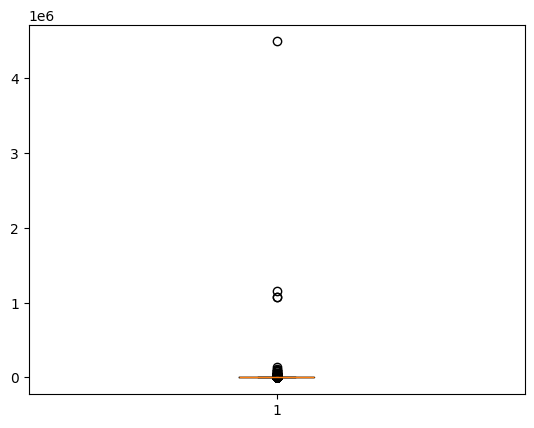

In [15]:
plt.boxplot(df_train['price'])
plt.show()

Как видно по графику, выбросов действительно много, поэтому удалим их

In [16]:
low_quant = df_train['price'].quantile(0.01)
high_quant = df_train['price'].quantile(0.99)

df_train = df_train[(df_train['price'] > low_quant) & (df_train['price'] < high_quant)]
df_train

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,1
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,1
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[Elevator, Dishwasher, Hardwood Floors]",40.8433,6824800,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,[https://photos.renthop.com/2/6824800_0682be16...,2800,620 W 171 Street,0
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.8198,6813268,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,[https://photos.renthop.com/2/6813268_1e6fcc32...,2395,3333 Broadway,1
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[Dining Room, Elevator, Pre-War, Laundry in Bu...",40.5765,6927093,-73.9554,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/6927093_93a52104...,1850,210 Brighton 15th St,1
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...",40.7448,6892816,-74.0017,c3cd45f4381ac371507090e9ffabea80,[https://photos.renthop.com/2/6892816_1a8d087a...,4195,350 West 21st Street,1


---
**Квантиль** — это значение, которое делит отсортированные данные на определённые части.

Примеры:

0.5-квантиль — это медиана: значение, ниже которого находится 50% всех данных.

0.25-квантиль — это такое значение, ниже которого 25% данных (также называется первым квартилем).

0.75-квантиль — это значение, ниже которого 75% данных (третий квартиль).

0.01-квантиль — это значение, ниже которого находятся 1% наблюдений (то есть крайние 1% по "нижнему хвосту").

---


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48343 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        48343 non-null  float64
 1   bedrooms         48343 non-null  int64  
 2   building_id      48343 non-null  object 
 3   created          48343 non-null  object 
 4   description      48343 non-null  object 
 5   display_address  48343 non-null  object 
 6   features         48343 non-null  object 
 7   latitude         48343 non-null  float64
 8   listing_id       48343 non-null  int64  
 9   longitude        48343 non-null  float64
 10  manager_id       48343 non-null  object 
 11  photos           48343 non-null  object 
 12  price            48343 non-null  int64  
 13  street_address   48343 non-null  object 
 14  interest_level   48343 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 6.9+ MB


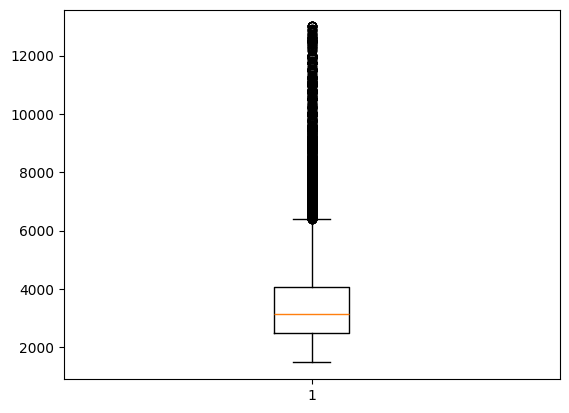

In [18]:
plt.boxplot(df_train['price'])
plt.show()

Посмотрим на гистограмму распределения целевого признака

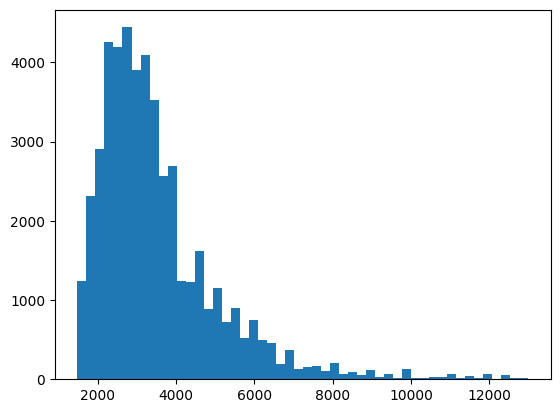

In [19]:
plt.hist(df_train['price'], bins=50)
plt.show()

После удаления выбросов распределение стало выглядить лучше

---
Гистограмма распределения price выглядит **асимметричной** — с длинным правым хвостом (то есть распределение "скошено вправо"). Это говорит о том, что у нас есть нормальные значения цен и относительно небольшое количество дорогих объектов, которые значительно дороже остальных.

Это распределение называется ***правоскошенным*** (right-skewed, или положительно скошенное).

---

<Axes: xlabel='price', ylabel='Count'>

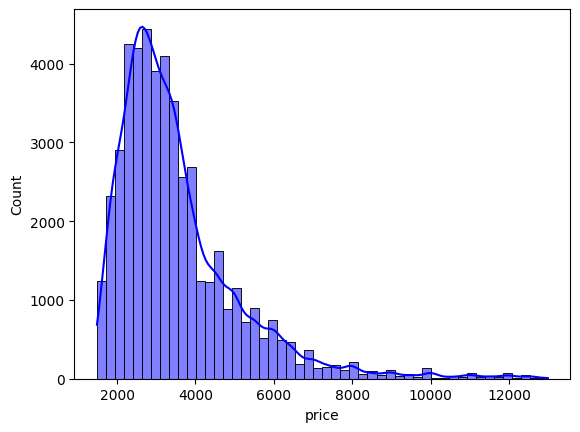

In [20]:
sns.histplot(df_train['price'], kde=True,
             bins= 50, color = 'blue')

In [21]:
from scipy import stats

# Убираем пропуски, если есть
price_data = df_train['price'].dropna()

# Применяем тест на нормальность
stat, p_value = stats.normaltest(price_data)

print(f"Статистика: {stat:.4f}, p-значение: {p_value:.4f}")
if p_value < 0.05:
    print("Распределение НЕ является нормальным (отвергаем H0)")
else:
    print("Распределение возможно нормальное (не отвергаем H0)")


Статистика: 20120.6250, p-значение: 0.0000
Распределение НЕ является нормальным (отвергаем H0)


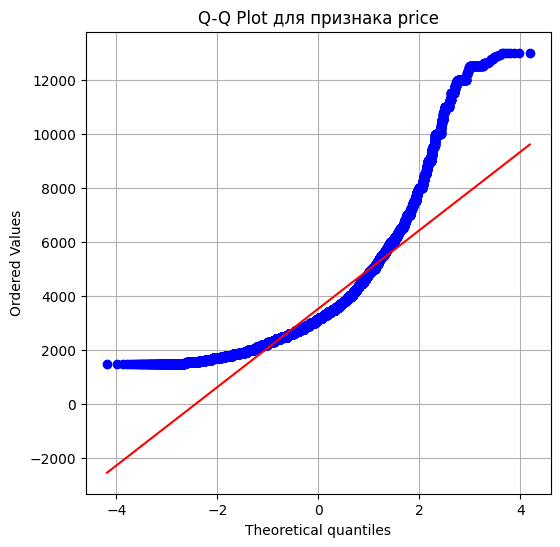

In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(price_data, dist="norm", plot=plt)
plt.title("Q-Q Plot для признака price")
plt.grid()
plt.show()

Попробую нормализовать данные

In [23]:
df_train = df_train.copy()

df_train['log_price'] = np.log1p(df_train['price'])


In [24]:
df_train['log_price'] = np.log1p(df_train['price'])


In [25]:
stat, p_value = stats.normaltest(price_data)

print(f"Статистика: {stat:.4f}, p-значение: {p_value:.4f}")
if p_value < 0.05:
    print("Распределение НЕ является нормальным (отвергаем H0)")
else:
    print("Распределение возможно нормальное (не отвергаем H0)")


Статистика: 20120.6250, p-значение: 0.0000
Распределение НЕ является нормальным (отвергаем H0)


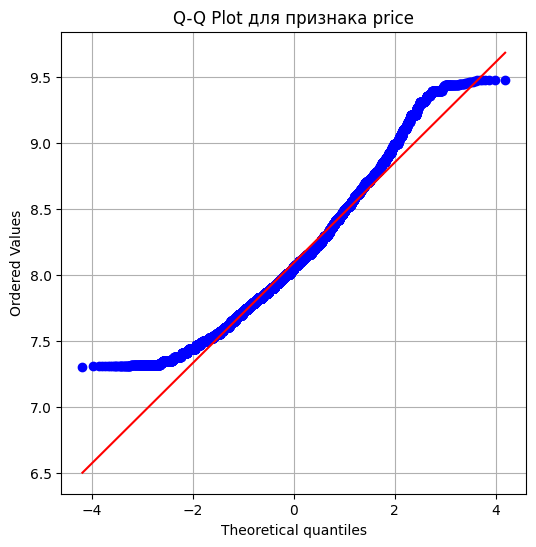

In [26]:
price_data = df_train['log_price']

plt.figure(figsize=(6, 6))
stats.probplot(price_data, dist="norm", plot=plt)
plt.title("Q-Q Plot для признака price")
plt.grid()
plt.show()

Как видно из Q-Q plot распределение стало более нормалным

Рассмотрим признак features

In [27]:
df_train['features']

,features
4,"[Dining Room, Pre-War, Laundry in Building, Di..."
6,"[Doorman, Elevator, Laundry in Building, Dishw..."
9,"[Doorman, Elevator, Laundry in Building, Laund..."
10,[]
15,"[Doorman, Elevator, Fitness Center, Laundry in..."
...,...
124000,"[Elevator, Dishwasher, Hardwood Floors]"
124002,"[Common Outdoor Space, Cats Allowed, Dogs Allo..."
124004,"[Dining Room, Elevator, Pre-War, Laundry in Bu..."
124008,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,..."


Посмотрим первый элемент в столбце features

In [28]:
df_train['features'].iloc[0]

['Dining Room',
 'Pre-War',
 'Laundry in Building',
 'Dishwasher',
 'Hardwood Floors',
 'Dogs Allowed',
 'Cats Allowed']

Уберем ненужные символы в тексте

In [29]:
symbols_to_remove = ["[", "]", "'", '"', " ", "' '"]

def remove(text):
    # Преобразуем список в строку, если это список
    if isinstance(text, list):
        text = ','.join(map(str, text))  # Преобразуем список в строку
    for symbol in symbols_to_remove:
        text = text.replace(symbol, "")
    if text == '':
      return None
    return text


In [30]:
df_train['features'] = df_train['features'].apply(lambda x: remove(x))

Удаляем строки, где features == None

In [31]:
df_train = df_train.dropna(subset=['features'])


In [32]:
df_train.shape

(45237, 16)

In [33]:
df_train['features'].iloc[0]

'DiningRoom,Pre-War,LaundryinBuilding,Dishwasher,HardwoodFloors,DogsAllowed,CatsAllowed'

In [34]:
df_train['features'].unique()

array(['DiningRoom,Pre-War,LaundryinBuilding,Dishwasher,HardwoodFloors,DogsAllowed,CatsAllowed',
       'Doorman,Elevator,LaundryinBuilding,Dishwasher,HardwoodFloors,NoFee',
       'Doorman,Elevator,LaundryinBuilding,LaundryinUnit,Dishwasher,HardwoodFloors',
       ...,
       'Elevator,FitnessCenter,HighSpeedInternet,HardwoodFloors,DogsAllowed,CatsAllowed',
       'Fireplace,Multi-Level,LaundryinUnit,HardwoodFloors',
       'ReducedFee,ExposedBrick'], dtype=object)

In [35]:
all_features = []

for index, row in df_train.iterrows():
  feature = row['features'].split(',')
  all_features.extend(feature)

Выделим уникальные значения features. Посмотрим на первые 25 значений.

In [36]:
unique_features = list(set(all_features))
unique_features[:25]

['oversizedcloset',
 '**THEPERFECTSHARE!*MASSIVE2BRHOME*GUTRENOVATED*LNDRYBLDG*PETSOK*HEARTOFTHEVILLAGE**',
 'CeilingFans',
 'SPACE',
 'triplex',
 'NewStainlessAppliances',
 'WindowBathroom',
 '**DIAMONDUWSDEAL!*MASSIVESTUDIO*EXPOSEDBRICK*DISHWASHER*PETSOK*STEPSTOTHEPARK!**',
 'GrandCentral',
 'DoublePannedSound-Proofwindows/Renovatedopenkitchenmarbleandstainlesssteelcountertops',
 '1.5baths',
 'BilliardsRoom',
 'garage',
 'lounge',
 'Businesscenter',
 'On-SiteAttendedGarage',
 'Healthclubwithpoolonthetopfloor',
 'PrivateRoofDeck',
 'CeilingFan',
 'HugeWalkInCloset',
 'renovatedkitchen',
 'Live-inSuper',
 'duplex',
 'AlcoveStudio',
 'openconceptkitchen']

In [37]:
len(unique_features)

1529

Определим топ-20 самых популярных features с помощью класса Counter.

In [38]:
counter = Counter(all_features)

top_20_features = counter.most_common(20)
top_20_features

[('Elevator', 25375),
 ('HardwoodFloors', 23146),
 ('CatsAllowed', 23135),
 ('DogsAllowed', 21652),
 ('Doorman', 20479),
 ('Dishwasher', 20081),
 ('NoFee', 17793),
 ('LaundryinBuilding', 16082),
 ('FitnessCenter', 12989),
 ('Pre-War', 8971),
 ('LaundryinUnit', 8437),
 ('RoofDeck', 6417),
 ('OutdoorSpace', 5132),
 ('DiningRoom', 4890),
 ('HighSpeedInternet', 4223),
 ('Balcony', 2898),
 ('SwimmingPool', 2643),
 ('LaundryInBuilding', 2564),
 ('NewConstruction', 2504),
 ('Terrace', 2177)]

'Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace'.

# 3.Генерация признаков

Добавим топ-20 features ('Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace') в качестве признаков в наш датасет

In [39]:
top_20_features = [feature for feature, count in top_20_features]
top_20_features

['Elevator',
 'HardwoodFloors',
 'CatsAllowed',
 'DogsAllowed',
 'Doorman',
 'Dishwasher',
 'NoFee',
 'LaundryinBuilding',
 'FitnessCenter',
 'Pre-War',
 'LaundryinUnit',
 'RoofDeck',
 'OutdoorSpace',
 'DiningRoom',
 'HighSpeedInternet',
 'Balcony',
 'SwimmingPool',
 'LaundryInBuilding',
 'NewConstruction',
 'Terrace']

In [40]:
for feature in top_20_features:
  df_train.loc[:, [feature]] = 0

df_train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"DiningRoom,Pre-War,LaundryinBuilding,Dishwashe...",40.7108,7170325,-73.9539,...,0,0,0,0,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"Doorman,Elevator,LaundryinBuilding,Dishwasher,...",40.7513,7092344,-73.9722,...,0,0,0,0,0,0,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"Doorman,Elevator,LaundryinBuilding,LaundryinUn...",40.7575,7158677,-73.9625,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"Doorman,Elevator,FitnessCenter,LaundryinBuilding",40.7439,7225292,-73.9743,...,0,0,0,0,0,0,0,0,0,0
16,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,This spectacular converted 3 bed apartment all...,East 16th Street,"Doorman,Elevator,Loft,Dishwasher,HardwoodFloor...",40.7348,7226687,-73.9865,...,0,0,0,0,0,0,0,0,0,0


Теперь нужно заполнить "1", если feature присутствует в features

In [41]:
for index, row in df_train.iterrows():
  for feature in top_20_features:
    if feature in row['features']:
      df_train.at[index, feature] = 1
df_train

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"DiningRoom,Pre-War,LaundryinBuilding,Dishwashe...",40.7108,7170325,-73.9539,...,0,0,0,1,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"Doorman,Elevator,LaundryinBuilding,Dishwasher,...",40.7513,7092344,-73.9722,...,0,0,0,0,0,0,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"Doorman,Elevator,LaundryinBuilding,LaundryinUn...",40.7575,7158677,-73.9625,...,1,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"Doorman,Elevator,FitnessCenter,LaundryinBuilding",40.7439,7225292,-73.9743,...,0,0,0,0,0,0,0,0,0,0
16,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,This spectacular converted 3 bed apartment all...,East 16th Street,"Doorman,Elevator,Loft,Dishwasher,HardwoodFloor...",40.7348,7226687,-73.9865,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"Elevator,Dishwasher,HardwoodFloors",40.8433,6824800,-73.9396,...,0,0,0,0,0,0,0,0,0,0
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"CommonOutdoorSpace,CatsAllowed,DogsAllowed,NoF...",40.8198,6813268,-73.9578,...,0,0,1,0,0,0,0,1,0,0
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"DiningRoom,Elevator,Pre-War,LaundryinBuilding,...",40.5765,6927093,-73.9554,...,1,0,0,1,0,0,0,0,0,0
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"Pre-War,LaundryinUnit,Dishwasher,NoFee,Outdoor...",40.7448,6892816,-74.0017,...,1,0,1,0,0,0,0,0,0,0


In [42]:
del df_train['features']
df_train

,bathrooms,bedrooms,building_id,created,description,display_address,latitude,listing_id,longitude,manager_id,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,...,0,0,0,1,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,...,1,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,...,0,0,0,0,0,0,0,0,0,0
16,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,This spectacular converted 3 bed apartment all...,East 16th Street,40.7348,7226687,-73.9865,30a7951cfc21240e8c46b2d079d292e5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,40.8433,6824800,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,...,0,0,0,0,0,0,0,0,0,0
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,40.8198,6813268,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,...,0,0,1,0,0,0,0,1,0,0
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,40.5765,6927093,-73.9554,a10db4590843d78c784171a107bdacb4,...,1,0,0,1,0,0,0,0,0,0
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,40.7448,6892816,-74.0017,c3cd45f4381ac371507090e9ffabea80,...,1,0,1,0,0,0,0,0,0,0


Extend our feature set with 'bathrooms', 'bedrooms', 'interest_level' and create a special variable feature_list with all feature names. Now we have 23 values. All models should be trained on these 23 features.

In [43]:
list(df_train.columns.values )

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level',
 'log_price',
 'Elevator',
 'HardwoodFloors',
 'CatsAllowed',
 'DogsAllowed',
 'Doorman',
 'Dishwasher',
 'NoFee',
 'LaundryinBuilding',
 'FitnessCenter',
 'Pre-War',
 'LaundryinUnit',
 'RoofDeck',
 'OutdoorSpace',
 'DiningRoom',
 'HighSpeedInternet',
 'Balcony',
 'SwimmingPool',
 'LaundryInBuilding',
 'NewConstruction',
 'Terrace']

In [44]:
df = df_train.copy()
df = df[['bathrooms',
        'bedrooms',
        'interest_level',
         'price',
          'Elevator',
'HardwoodFloors',
 'CatsAllowed',
 'DogsAllowed',
 'Doorman',
 'Dishwasher',
 'NoFee',
 'LaundryinBuilding',
 'FitnessCenter',
 'Pre-War',
 'LaundryinUnit',
 'RoofDeck',
 'OutdoorSpace',
 'DiningRoom',
 'HighSpeedInternet',
 'Balcony',
 'SwimmingPool',
 'LaundryInBuilding',
 'NewConstruction',
 'Terrace']].reset_index()
df

,index,bathrooms,bedrooms,interest_level,price,Elevator,HardwoodFloors,CatsAllowed,DogsAllowed,Doorman,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
0,4,1.0,1,1,2400,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1,6,1.0,2,0,3800,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9,1.0,2,1,3495,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,15,1.0,0,0,2795,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,16,1.0,3,0,7200,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45232,124000,1.0,3,0,2800,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45233,124002,1.0,2,1,2395,1,0,1,1,1,...,0,0,1,0,0,0,0,1,0,0
45234,124004,1.0,1,1,1850,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,0
45235,124008,1.0,2,1,4195,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [45]:
df.shape

(45237, 25)

#4.Реализация моделей - Линейная регрессия

In [46]:
X = df.drop(labels=['price', 'index'], axis=1)
y = df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

**Аналитическое решение (fit_analytical):**

Мы используем нормальное уравнение для нахождения весов. Это точное решение, но оно может быть computationally expensive для больших данных.

Формула:
$ weights=(X^T X)^{-1} X^Ty $

**Градиентный спуск (fit_gradient_descent):**

Мы итеративно обновляем веса, двигаясь в направлении, противоположном градиенту функции потерь.

Градиент вычисляется как
$2mX^T(X⋅weights−y)$, где
m — количество примеров.

**Стохастический градиентный спуск (fit_stochastic_gradient_descent):**

В отличие от обычного градиентного спуска, на каждом шаге мы используем только один случайный пример для обновления весов.

Это делает метод более быстрым для больших данных, но менее стабильным.

**Метод predict:**

После обучения модели мы используем веса для предсказания целевой переменной на новых данных.

In [47]:
# X_train = X_train.values  # Преобразуем DataFrame в numpy массив
# y_train = y_train.values

In [48]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None

    def fit_analytical(self, X, y):
        """Аналитическое решение (МНК)"""
        X = np.array(X)  # Конвертируем в numpy array
        y = np.array(y).reshape(-1, 1)  # Конвертируем и делаем одномерным
        X_b = np.c_[np.ones((X.shape[0], 1)), X] # X + bias
        self.weights = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def fit_gradient_descent(self, X, y, learning_rate=0.01, n_iters=1000):
        """Полный градиентный спуск"""
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.weights = np.zeros((X_b.shape[1], 1)) #  вектор начальных весов, полностью заполненный нулями.

        for _ in range(n_iters):
            gradients = 2/X_b.shape[0] * X_b.T.dot(X_b.dot(self.weights) - y)
            self.weights -= learning_rate * gradients

    def fit_stochastic_gradient_descent(self, X, y, learning_rate=0.01, n_iters=10, batch_size=32):
        """Стохастический градиентный спуск с мини-батчами"""
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.weights = np.zeros((X_b.shape[1], 1))
        amount_samples = X_b.shape[0]

        #  Главный цикл: обучаем модель. Цикл по эпохам. Каждая эпоха — один проход по всему датасету.
        for _ in range(n_iters):
            # Перемешиваем данные каждую эпоху
            indices = np.random.permutation(amount_samples)
            X_shuffled = X_b[indices]
            y_shuffled = y[indices]

            # Внутренний цикл: пробегаемся по мини-батчам.
            for i in range(0, amount_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                gradients = 2/X_batch.shape[0] * X_batch.T.dot(X_batch.dot(self.weights) - y_batch)
                self.weights -= learning_rate * gradients

    def predict(self, X):
        X = np.array(X)  # Конвертируем в numpy array
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.weights).flatten()

np.linalg.pinv(...) — это псевдообратная матрица
→ безопасная версия (XᵀX)⁻¹, которая работает даже если матрица XᵀX вырожденная (необратимая или почти необратимая).

## 4.1 Метрики качества линейных регрессионных моеделей

**Коэффициент детерминации $R^2$** - cтатистический показатель, отражающий объясняющую способность регрессии
f:X→Y
 и определяемый как доля дисперсии зависимой переменной, объясненная регрессионной моделью с данным набором независимых переменных. Обычно определяется как единица минус доля необъясненной дисперсии, т.е:

 $ R^2 = \frac{\sum_{i}(y_i - y_i^{pred})^2}{\sum_{i}(y_i - y_i^{mean})^2} = 1 - \frac{SSE}{SST}$

In [49]:
def my_r2(y_true, y_pred):
    y_true = np.ravel(y_true)  # Превращаем в одномерный массив
    y_pred = np.ravel(y_pred)  # Превращаем в одномерный массив

    SSE = np.sum((y_true - y_pred) ** 2)
    SST = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - SSE / SST


ravel() используется для быстрого приведения к одномерному виду без лишних копий.

flatten() нужен, если требуется гарантированная копия (например, для безопасности или изменений).

$MAE = \frac{1}{m} * \sum_{i=1}^{n} |y_i - y_i^{pred}|$

In [50]:
def my_mae(y_true, y_pred):
  y_true = np.ravel(y_true)  # Превращаем в одномерный массив
  y_pred = np.ravel(y_pred)  # Превращаем в одномерный массив

  return np.mean(np.abs(y_true - y_pred))

$ RMSE = \sqrt{\frac{1}{m} * \sum_{i=1}^{n} (y_i - y_i^{pred})^2}$

In [51]:
def my_rmse(y_true, y_pred):
  y_true = np.ravel(y_true)  # Превращаем в одномерный массив
  y_pred = np.ravel(y_pred)  # Превращаем в одномерный массив

  return np.sqrt(np.mean((y_true - y_pred)**2))

Make predictions with your algorithm and estimate the model with MAE, RMSE and R2 metrics.

Для удобства создам таблицу для R2, MAE, RMSE, где будет нагляднее видно сзодство (или различие) рассчитанных метрик для моих моделей и модели из sklearn

In [52]:
result_R2 = pd.DataFrame(columns=['model', 'R^2', 'MAE', 'RMSE'])

In [53]:
my_lin_reg = MyLinearRegression()
my_lin_reg.fit_stochastic_gradient_descent(X_train, y_train, learning_rate = 0.001, n_iters = 1000)
y_pred = my_lin_reg.predict(X_test)
y_pred

array([3163.37038404, 3343.51654969, 5016.49590089, ..., 2267.32345894,
       3270.63666013, 2827.99088981])

In [54]:
r2 = my_r2(y_test, y_pred)
rmse = my_rmse(y_test, y_pred)
mae = my_mae(y_test, y_pred)

In [55]:
result_R2.loc[len(result_R2.index)] = ['My linear model stochastic gradient descent', r2, mae, rmse]

In [56]:
my_lin_reg = MyLinearRegression()
my_lin_reg.fit_analytical(X_train, y_train)
y_pred = my_lin_reg.predict(X_test)

In [57]:
r2 = my_r2(y_test, y_pred)
rmse = my_rmse(y_test, y_pred)
mae = my_mae(y_test, y_pred)

In [58]:
result_R2.loc[len(result_R2.index)] = ['My linear model fit_analytical', r2, mae, rmse]

In [59]:
my_lin_reg = MyLinearRegression()
my_lin_reg.fit_gradient_descent(X_train, y_train, learning_rate = 0.01, n_iters = 1000)
y_pred = my_lin_reg.predict(X_test)

r2 = my_r2(y_test, y_pred)
rmse = my_rmse(y_test, y_pred)
mae = my_mae(y_test, y_pred)

result_R2.loc[len(result_R2.index)] = ['My linear model gradient descent', r2, mae, rmse]

In [60]:
orig_lin_reg = LinearRegression()
orig_lin_reg.fit(X_train, y_train)
pred = orig_lin_reg.predict(X_test)

In [61]:
r2 = my_r2(y_test, pred)
rmse = my_rmse(y_test, pred)
mae = my_mae(y_test, pred)

result_R2.loc[len(result_R2.index)] = ['Sklearn linear model', r2, mae, rmse]

In [62]:
result_R2

,model,R^2,MAE,RMSE
0,My linear model stochastic gradient descent,0.614038,679.040409,984.176057
1,My linear model fit_analytical,0.614155,681.701637,984.027676
2,My linear model gradient descent,0.614015,681.122504,984.205777
3,Sklearn linear model,0.614155,681.701637,984.027676


Initialize LinearRegression() from sklearn.linear_model, fit the model, and predict the training and test parts as in the previous lesson.

In [63]:
results = pd.DataFrame(columns=['model', 'R^2 test', 'R^2 train', 'MAE test', 'MAE train', 'RMSE test', 'RMSE train'])

In [64]:
orig_lin_reg = LinearRegression()
orig_lin_reg.fit(X_train, y_train)

pred_test = orig_lin_reg.predict(X_test)
pred_train = orig_lin_reg.predict(X_train)

In [65]:
r2_train = my_r2(y_train, pred_train)
r2_test = my_r2(y_test, pred_test)

rmse_train = my_rmse(y_train, pred_train)
rmse_test = my_rmse(y_test, pred_test)

mae_train = my_mae(y_train, pred_train)
mae_test = my_mae(y_test, pred_test)

In [66]:
results.loc[len(results.index)] = ['Sklearn linear model', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [67]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676


In [68]:
my_lin_reg = MyLinearRegression()
my_lin_reg.fit_stochastic_gradient_descent(X_train, y_train, learning_rate = 0.001, n_iters = 1000)

pred_test = my_lin_reg.predict(X_test)
pred_train = my_lin_reg.predict(X_train)

In [69]:
r2_train = my_r2(y_train, pred_train)
r2_test = my_r2(y_test, pred_test)

rmse_train = my_rmse(y_train, pred_train)
rmse_test = my_rmse(y_test, pred_test)

mae_train = my_mae(y_train, pred_train)
mae_test = my_mae(y_test, pred_test)

In [70]:
results.loc[len(results.index)] = ['My linear model stochastic_gradient_descent', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [71]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617


# 5.Реализация регуляризованных моделей — Ridge, Lasso, ElasticNet

## 5.1 Ridge

  **L2 - регуляризация(Ridge-регресия):**

  Добавляет в функцию потерь штраф  L2-нормы (сумму квадратов коэффициентов):

  $ J(ω) = ||Xω - y ||^2 + λ||ω||^2 = ||Xω-y||^2 + λω^Tω$,

  где λ > 0 - коэффициент регуляризации. Оптимальные веса находятся путем решения:

  <tex>$\frac{∂J(ω)}{∂ω} $<tex> = $2X^T(Xω - y) + 2λω = 0$

  Решая уравнение, получаем модифицированную нормальную формулу:

   $ω = (X^TX+λI)^{-1}X^Ty$,

   здесь I - единичная матрица. Матрица X^TX+λ всегда обратима, даже если X^TX вырожденная.

   Эффект: Ridge-регуляризация сглаживает веса, уменьшая их величины, но не зануляет их.

   $ω = (X^TX+λI)^{-1}X^Ty$,

   здесь I - единичная матрица. Матрица X^TX+λ всегда обратима, даже если X^TX вырожденная.


In [72]:
class MyRidge() :
    def __init__(self, alpha=1.0):
        self.alpha = alpha #коэффициент регуляризации (чем выше — тем сильнее штраф за большие веса)
        self.weights = None
        self.bias = None #свободный член (bias)

    def fit(self, X, y):
        # Добавляем дополнительныю коллонку единиц
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        I = np.eye(X.shape[1])
        I[0, 0] = 0 # мы не хотим штрафовать свободный член
        self.weights = np.linalg.inv(X.T.dot(X) + self.alpha * I).dot(X.T).dot(y)

        # сохраняем отдельно свободный член, а остальные коэффициенты — это веса признаков
        self.bias = self.weights[0]
        self.weights = self.weights[1:]

    def predict(self, X):
        return X.dot(self.weights) + self.bias

Обучение модели и предсказания по тестовой и тренировочной выборкам

In [73]:
my_ridge = MyRidge()
my_ridge.fit(X_train, y_train)

pred_test = my_ridge.predict(X_test)
pred_train = my_ridge.predict(X_train)

Расчет метрик

In [74]:
r2_train = my_r2(y_train, pred_train)
r2_test = my_r2(y_test, pred_test)

rmse_train = my_rmse(y_train, pred_train)
rmse_test = my_rmse(y_test, pred_test)

mae_train = my_mae(y_train, pred_train)
mae_test = my_mae(y_test, pred_test)

In [75]:
results.loc[len(results.index)] = ['My Ridge', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

Обучение модели из библиотеки Sklearn и получение предсказаний

In [76]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

Расчет метрик

In [77]:
r2_train_ridge = my_r2(y_train, ridge_train_pred)
r2_test_ridge = my_r2(y_test, ridge_test_pred)

rmse_train_ridge = root_mean_squared_error(y_train, ridge_train_pred)
rmse_test_ridge = root_mean_squared_error(y_test, ridge_test_pred)

mae_ridge_train_ridge = mean_absolute_error(y_train, ridge_train_pred)
mae_ridge_test_ridge = mean_absolute_error(y_test, ridge_test_pred)

In [78]:
results.loc[len(results.index)] = ['Lib Ridge', r2_train_ridge, r2_test_ridge, mae_ridge_train_ridge, mae_ridge_test_ridge, rmse_train_ridge, rmse_test_ridge]

In [79]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617
2,My Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
3,Lib Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604


## 5.2.Lasso

Когда добавляются регуляризации L1 и L2, к функции потерь добавляются дополнительные члены, которые штрафуют большие значения весов ω. Это изменяет аналитическое решение.

**L1 - регуляризация(Лассо-регресия):**

 Добавляет к функции потерь L1-норму (сумму модулей коэффициентов):

  $ J(ω) = ||Xω - y ||^2 + λ \sum_{i=1}^{n}|ω_{i}| $

  L1 - регуляризация не имеет аналитического решения, потому что абсолютное значение делает уравнение недифферинцируемым в точке $ ω_i $ = 0.

  Поэтому решение ищется численно, например, с помощью градиентного спуска или методом координатного спуска.

  Эффект:  Lasso-регуляризация зануляет некоторые веса $ ω_i $, что делает модель разреженной.


In [80]:
class MyLasso:
  def __init__(self, n_iter=1000, eps = 0.0001, learning_rate = 0.03, alpha=0.1) -> None:
    self.weights = 0
    self.n_iter = n_iter
    self.eps = eps #  критерий остановки: если градиент стал очень маленьким, остановимся
    self.learning_rate = learning_rate # шаг обучения
    self.alpha = alpha #коэфф регуляризации

  def fit(self, X, Y):
    learning_rate = self.learning_rate
    alpha = self.alpha
    amount_samples, amount_features = X.shape
    weights = np.random.normal(size=amount_features) #тут можно было нулями, но для лучшей практики (для нейросетей) лучше рандомными значениями
    np_soft_sign = np.vectorize(lambda x, eps=1e-7: np.sign(x) if abs(x) > eps else x / eps)

    #Основной цикл обучения
    for _ in range(self.n_iter):
      signw = np_soft_sign(self.weights) #signw — градиент L1 по весам
      pred = X.dot(weights)
      err = pred - np.array(Y.iloc[:,0])
      grad = 2 * X.T.dot(err)/amount_samples + alpha*signw
      if (weights.max()>1e25) or (np.absolute(learning_rate * grad).sum() < self.eps):
        break # Если веса "взрываются" или градиент почти исчез — останавливаем обучение (условие выхода)
      weights -= learning_rate * grad
    self.weights = weights

  def predict(self, X):
    return X.dot(self.weights)  # форма (n_samples,) или (n_samples, 1)

---
L1-регуляризация требует градиента от функции abs(w), а её производная — это sign(w), но sign(0) не определён.
Поэтому мы используем "мягкий" sign (soft sign), чтобы избежать проблем с нулевыми весами.

In [81]:
my_lasso = MyLasso()
my_lasso.fit(X_train, y_train)
y_pred = my_lasso.predict(X_test)
pred_test = my_lasso.predict(X_test)
pred_train = my_lasso.predict(X_train)

In [82]:
r2_train = my_r2(y_train, pred_train)
r2_test = my_r2(y_test, pred_test)

rmse_train = my_rmse(y_train, pred_train)
rmse_test = my_rmse(y_test, pred_test)

mae_train = my_mae(y_train, pred_train)
mae_test = my_mae(y_test, pred_test)

In [83]:
results.loc[len(results.index)] = ['My Lasso', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [84]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617
2,My Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
3,Lib Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
4,My Lasso,0.592537,0.591250,700.573835,699.257133,1023.844556,1012.814268


In [85]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_train_pred = lasso_model.predict(X_train)
lasso_test_pred = lasso_model.predict(X_test)

In [86]:
r2_train_lasso = my_r2(y_train, lasso_train_pred)
r2_test_lasso = my_r2(y_test, lasso_test_pred)

rmse_train_lasso = root_mean_squared_error(y_train, lasso_train_pred)
rmse_test_lasso = root_mean_squared_error(y_test, lasso_test_pred)

mae_lasso_train_ridge = mean_absolute_error(y_train, lasso_train_pred)
mae_lasso_test_ridge = mean_absolute_error(y_test, lasso_test_pred)

In [87]:
results.loc[len(results.index)] = ['Lib Lasso', r2_train_lasso, r2_test_lasso,
                                   mae_lasso_train_ridge, mae_lasso_test_ridge,
                                   rmse_train_lasso, rmse_test_lasso]

In [88]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617
2,My Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
3,Lib Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
4,My Lasso,0.592537,0.591250,700.573835,699.257133,1023.844556,1012.814268
5,Lib Lasso,0.610948,0.614046,688.229021,681.129834,1000.446414,984.167068


## 5.3. Elastic Net

In [89]:
class MyElasticNet:
    def __init__(self, l1_ratio=0.5, n_cycles=500, eps=0.1, alpha=0.001, learning_rate=0.01, print_eps=False):
        self.l1_ratio = l1_ratio
        self.n_cycles = n_cycles
        self.eps = eps
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.print_eps = print_eps
        self.weights = None

    def fit(self, X, Y):
        n_samples, n_features = X.shape
        self.weights = np.random.normal(size=n_features)

        soft_sign = np.vectorize(lambda x, eps=1e-7: np.sign(x) if abs(x) > eps else x / eps)

        for i in range(self.n_cycles):
            pred = X.dot(self.weights)
            err = pred - np.array(Y.iloc[:, 0])

            grad_mse = 2 * X.T.dot(err) / n_samples
            grad_l2 = self.weights
            grad_l1 = soft_sign(self.weights)

            grad = grad_mse + self.alpha * ((1 - self.l1_ratio) * grad_l2 + self.l1_ratio * grad_l1)

            if (self.weights.max() > 1e25) or (np.absolute(self.learning_rate * grad).sum() < self.eps):
                break

            self.weights -= self.learning_rate * grad

    def predict(self, X):
        return X.dot(self.weights)


learning_rate (шаг обучения)	- Параметр оптимизаци. Определяет, насколько сильно ты обновляешь веса на каждом шаге обучения


alpha (регуляризация) -	Гиперпараметр модели.	Определяет, насколько сильно ты штрафуешь большие веса, чтобы избежать переобучения

In [90]:
my_elastic = MyElasticNet()
my_elastic.fit(X_train, y_train)
y_pred = my_elastic.predict(X_test)
pred_test = my_elastic.predict(X_test)
pred_train = my_elastic.predict(X_train)

In [91]:
r2_train_my_elastic = my_r2(y_train, pred_train)
r2_test_my_elastic = my_r2(y_test, pred_test)

rmse_train_my_elastic = root_mean_squared_error(y_train, pred_train)
rmse_test_my_elastic = root_mean_squared_error(y_test, pred_test)

mae_my_elastic_train_ridge = mean_absolute_error(y_train, pred_train)
mae_my_elastic_test_ridge = mean_absolute_error(y_test, pred_test)

In [92]:
results.loc[len(results.index)] = ['My Elastic Net', r2_train_my_elastic, r2_test_my_elastic,
                                   mae_my_elastic_train_ridge, mae_my_elastic_test_ridge,
                                   rmse_train_my_elastic, rmse_test_my_elastic]

In [93]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617
2,My Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
3,Lib Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
4,My Lasso,0.592537,0.591250,700.573835,699.257133,1023.844556,1012.814268
5,Lib Lasso,0.610948,0.614046,688.229021,681.129834,1000.446414,984.167068
6,My Elastic Net,0.588382,0.588918,707.460917,704.965337,1029.051679,1015.699228


In [94]:
elastic = ElasticNet()
elastic.fit(X_train, y_train)
elastic_train_pred = elastic.predict(X_train)
elastic_test_pred = elastic.predict(X_test)

In [95]:
r2_train_el = my_r2(y_train, elastic_train_pred)
r2_test_el = my_r2(y_test, elastic_test_pred)

rmse_train_el = root_mean_squared_error(y_train, elastic_train_pred)
rmse_test_el = root_mean_squared_error(y_test, elastic_test_pred)

mae_train_el = mean_absolute_error(y_train, elastic_train_pred)
mae_test_el = mean_absolute_error(y_test, elastic_test_pred)

In [96]:
results.loc[len(results.index)] = ['Lib Elastic Net', r2_train_el, r2_test_el,
                                   mae_train_el, mae_test_el,
                                   rmse_train_el, rmse_test_el]

In [97]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617
2,My Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
3,Lib Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
4,My Lasso,0.592537,0.591250,700.573835,699.257133,1023.844556,1012.814268
5,Lib Lasso,0.610948,0.614046,688.229021,681.129834,1000.446414,984.167068
6,My Elastic Net,0.588382,0.588918,707.460917,704.965337,1029.051679,1015.699228
7,Lib Elastic Net,0.476161,0.484526,783.042676,772.766950,1160.884858,1137.376370


# **6. Нормализация признаков**

**Когда нормализация признаков обязательна:**

1. *Методы, основанные на расстояниях (KNN, K-means, SVM с RBF-ядром)*


Почему: Эти алгоритмы используют расстояния между точками данных (например, евклидово расстояние). Если признаки имеют разный масштаб, признаки с большими значениями будут доминировать при расчете расстояния.

Пример: В данных о жилье площадь (50–200 м²) и цена (1–10 млн руб.) — без нормализации цена "перевесит" площадь.

2. *Градиентный спуск (линейная регрессия, нейронные сети)*

Почему: Признаки разного масштаба приводят к "оврагоподобной" поверхности ошибок, что замедляет сходимость. Нормализация ускоряет обучение.

Пример: В логистической регрессии для прогноза заболевания возраст (0–100) и уровень глюкозы (70–300 мг/дл) требуют нормализации.

3. *Методы с регуляризацией (Ridge, Lasso)*

Почему: Штрафные коэффициенты применяются одинаково ко всем признакам. Если признаки не нормализованы, регуляризация будет несправедливо сильнее влиять на признаки с меньшим масштабом.

Пример: В Lasso-регрессии признак "количество комнат" (1–5) может быть "занулен" раньше, чем "площадь" (30–200 м²), даже если он информативен.

4. *PCA (метод главных компонент)*

Почему: PCA чувствителен к дисперсии признаков. Признаки с большей дисперсией (из-за масштаба) будут доминировать при выделении компонент.

Пример: Анализ данных о клиентах: доход (в тысячах) и возраст (в годах) — без нормализации PCA выделит компоненту, ориентированную на доход.



**Когда нормализация не обязательна (или даже вредна):**

1. *Древовидные модели (Decision Trees, Random Forest, XGBoost)*

Почему: Эти алгоритмы разделяют данные по пороговым значениям, а не используют расстояния или градиенты. Масштаб признаков не влияет на работу.

Пример: В задаче классификации текстов (TF-IDF) нормализация может изменить интерпретацию важности слов.

2. *Методы, инвариантные к масштабу (например, Naive Bayes)*

Почему: Они работают с вероятностями, а не с абсолютными значениями признаков.

Пример: Классификация спама: частота слов (0–100) и длина письма (100–1000 символов) — нормализация не нужна.

3. *Когда важна интерпретация коэффициентов*

Почему: Нормализация меняет масштаб коэффициентов, что усложняет их объяснение.

Пример: В экономической модели регрессии для анализа влияния ВВП (в триллионах) и инфляции (в процентах) нормализация сделает коэффициенты менее понятными.

4. *Бинарные или категориальные признаки*

Почему: Они уже находятся в сопоставимом масштабе (например, 0/1 или one-hot encoding).

Пример: Признак "пол" (0/1) не требует нормализации, даже если другие признаки непрерывные.

### **6.1. MinMaxScaler: математическая формула**

**MinMaxScaler** масштабирует признаки в заданный диапазон (по умолчанию `[0, 1]`). Формула:

$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$

где:
- (X) — исходное значение признака,

- $(X_{\text{min}})$ — минимальное значение признака в выборке,

- $(X_{\text{max}})$ — максимальное значение.

Если нужно масштабировать в другой диапазон `[a, b]`:

$
X_{\text{scaled}} = a + \frac{(X - X_{\text{min}})(b - a)}{X_{\text{max}} - X_{\text{min}}}
$

In [98]:
def MyMinMaxScaler(X, a=0, b = 1):
  X_scaled = X.copy()
  for column in X_scaled.columns:
    X_scaled[column] = a + (X_scaled[column] - X_scaled[column].min())*(b-a) / (X_scaled[column].max() - X_scaled[column].min())
  return X_scaled.to_numpy()

In [99]:
my_scaled_data = MyMinMaxScaler(X_train)

In [100]:
min_max = MinMaxScaler()
lib_scaled_data = min_max.fit_transform(X_train)

In [101]:
print("Разница между моей и sklearn реализацией:\n",
      np.abs(my_scaled_data - lib_scaled_data))

Разница между моей и sklearn реализацией:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [102]:
mean_absolute_error(lib_scaled_data, my_scaled_data)

4.755162309455892e-20

## **6.2. StandardScaler**


**StandardScaler** стандартизирует признаки, приводя их к среднему `0` и стандартному отклонению `1`:

$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$

где:
- $\mu$— среднее значение признака,
- $\sigma$ — стандартное отклонение.


In [103]:
def MyStandardScaler(X):
  X_scaled = X.copy()
  for column in X_scaled.columns:
    X_scaled[column] = (X_scaled[column] - X_scaled[column].mean())/X_scaled[column].std()
  return X_scaled.to_numpy()

In [104]:
my_standard_sc = MyStandardScaler(X_train)

In [105]:
stand_sc = StandardScaler()
lib_standard_scaler = stand_sc.fit_transform(X_train)

In [106]:
print("Разница между моей и sklearn реализацией:\n",
      np.abs(my_standard_sc - lib_standard_scaler))

Разница между моей и sklearn реализацией:
 [[6.08279825e-06 6.67400958e-06 3.66952373e-05 ... 3.39880677e-06
  5.75370388e-05 3.11731740e-06]
 [6.08279825e-06 5.81310306e-06 1.41598731e-05 ... 3.39880677e-06
  3.31776296e-06 3.11731740e-06]
 [6.08279825e-06 1.91611222e-05 8.37549115e-06 ... 3.39880677e-06
  3.31776296e-06 3.11731740e-06]
 ...
 [6.08279825e-06 5.81310306e-06 8.37549115e-06 ... 3.39880677e-06
  3.31776296e-06 3.11731740e-06]
 [6.08279825e-06 5.81310306e-06 8.37549115e-06 ... 3.39880677e-06
  3.31776296e-06 3.11731740e-06]
 [2.39670804e-05 5.81310306e-06 8.37549115e-06 ... 3.39880677e-06
  3.31776296e-06 3.11731740e-06]]


In [107]:
mean_absolute_error(lib_standard_scaler, my_standard_sc)

1.0645499491619448e-05

# 7.**Обучение моделей с нормализацией**

## **7.1. Обучения с MyMinMaxScaler**

1. Нормализуем данные с помощью MyMinMaxScaler

In [108]:
X_train_mms = MyMinMaxScaler(X_train)
X_test_mms = MyMinMaxScaler(X_test)

In [109]:
y_train_mms = y_train
y_test_mms = y_test

2. Обучим модель MyLinearRegression, MyRidge, MyLasso, MyElasticNet c нормализованными данными

In [110]:
lin_reg_mms = MyLinearRegression()
lin_reg_mms.fit_stochastic_gradient_descent(X_train_mms, y_train)

y_train_predict_lr_mms = lin_reg_mms.predict(X_train_mms)
y_test_predict_lr_mms = lin_reg_mms.predict(X_test_mms)

In [111]:
ridge_mms = MyRidge()
ridge_mms.fit(X_train_mms, y_train)

y_train_predict_ridge_mms = ridge_mms.predict(X_train_mms)
y_test_predict_ridge_mms = ridge_mms.predict(X_test_mms)

In [112]:
lasso_mms = MyLasso()
lasso_mms.fit(X_train_mms, y_train)

y_train_predict_lasso_mms = lasso_mms.predict(X_train_mms)
y_test_predict_lasso_mms = lasso_mms.predict(X_test_mms)

In [113]:
el_n_mms = MyElasticNet()
el_n_mms.fit(X_train_mms, y_train)

y_train_predict_eln_mms = el_n_mms.predict(X_train_mms)
y_test_predict_eln_mms = el_n_mms.predict(X_test_mms)

## **7.2. Обучения с MyStandardScaler**

1. Нормализуем данные с помощью MyStandardScaler

In [114]:
X_ss = MyStandardScaler(X)
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_ss, y, test_size=0.2, random_state=21)

2. Обучим модель MyLinearRegression, MyRidge, MyLasso, MyElasticNet c нормализованными данными

In [115]:
lin_reg_ss = MyLinearRegression()
lin_reg_ss.fit_stochastic_gradient_descent(X_train_ss, y_train)

y_train_predict_lr_ss = lin_reg_ss.predict(X_train_ss)
y_test_predict_lr_ss = lin_reg_ss.predict(X_test_ss)

In [116]:
ridge_ss = MyRidge()
ridge_ss.fit(X_train_ss, y_train)

y_train_predict_ridge_ss = ridge_ss.predict(X_train_ss)
y_test_predict_ridge_ss = ridge_ss.predict(X_test_ss)

In [117]:
lasso_ss = MyLasso()
lasso_ss.fit(X_train_ss, y_train)

y_train_predict_lasso_ss = lasso_ss.predict(X_train_ss)
y_test_predict_lasso_ss = lasso_ss.predict(X_test_ss)

In [118]:
el_n_ss = MyElasticNet()
el_n_ss.fit(X_train_ss, y_train)

y_train_predict_eln_ss = el_n_ss.predict(X_train_ss)
y_test_predict_eln_ss = el_n_ss.predict(X_test_ss)

## **7.3. Расчет метрик $R^2$, MAE, RMSE**

1. MyLinearRegression + MyMinMaxScaler

In [119]:
r2_train = my_r2(y_train_mms, y_train_predict_lr_mms)
r2_test = my_r2(y_test_mms, y_test_predict_lr_mms)

rmse_train = my_rmse(y_train_mms, y_train_predict_lr_mms)
rmse_test = my_rmse(y_test_mms, y_test_predict_lr_mms)

mae_train = my_mae(y_train_mms, y_train_predict_lr_mms)
mae_test = my_mae(y_test_mms, y_test_predict_lr_mms)

In [120]:
results.loc[len(results.index)] = ['MyLinearRegression + MyMinMaxScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

2. MyRidge + MyMinMaxScaler

In [121]:
r2_train = my_r2(y_train_mms, y_train_predict_ridge_mms)
r2_test = my_r2(y_test_mms, y_test_predict_ridge_mms)

rmse_train = my_rmse(y_train_mms, y_train_predict_ridge_mms)
rmse_test = my_rmse(y_test_mms, y_test_predict_ridge_mms)

mae_train = my_mae(y_train_mms, y_train_predict_ridge_mms)
mae_test = my_mae(y_test_mms, y_test_predict_ridge_mms)

In [122]:
results.loc[len(results.index)] = ['MyRidge + MyMinMaxScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

3. MyLasso + MyMinMaxScaler

In [123]:
r2_train = my_r2(y_train_mms, y_train_predict_lasso_mms)
r2_test = my_r2(y_test_mms, y_test_predict_lasso_mms)

rmse_train = my_rmse(y_train_mms, y_train_predict_lasso_mms)
rmse_test = my_rmse(y_test_mms, y_test_predict_lasso_mms)

mae_train = my_mae(y_train_mms, y_train_predict_lasso_mms)
mae_test = my_mae(y_test_mms, y_test_predict_lasso_mms)

In [124]:
results.loc[len(results.index)] = ['MyLasso + MyMinMaxScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

4. MyElastic_Net + MyMinMaxScaler

In [125]:
r2_train = my_r2(y_train_mms, y_train_predict_eln_mms)
r2_test = my_r2(y_test_mms, y_test_predict_eln_mms)

rmse_train = my_rmse(y_train_mms, y_train_predict_eln_mms)
rmse_test = my_rmse(y_test_mms, y_test_predict_eln_mms)

mae_train = my_mae(y_train_mms, y_train_predict_eln_mms)
mae_test = my_mae(y_test_mms, y_test_predict_eln_mms)

In [126]:
results.loc[len(results.index)] = ['MyElastic_Net + MyMinMaxScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [127]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617
2,My Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
3,Lib Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
4,My Lasso,0.592537,0.591250,700.573835,699.257133,1023.844556,1012.814268
5,Lib Lasso,0.610948,0.614046,688.229021,681.129834,1000.446414,984.167068
6,My Elastic Net,0.588382,0.588918,707.460917,704.965337,1029.051679,1015.699228
7,Lib Elastic Net,0.476161,0.484526,783.042676,772.766950,1160.884858,1137.376370
8,MyLinearRegression + MyMinMaxScaler,0.550562,0.133977,747.846007,1212.965065,1075.287886,1474.231086
9,MyRidge + MyMinMaxScaler,0.611040,-1.392161,688.953512,2141.030626,1000.328313,2450.168532


5. MyLinearRegression + MyStandardScaler

In [128]:
r2_train = my_r2(y_train_ss, y_train_predict_lr_ss)
r2_test = my_r2(y_test_ss, y_test_predict_lr_ss)

rmse_train = my_rmse(y_train_ss, y_train_predict_lr_ss)
rmse_test = my_rmse(y_test_ss, y_test_predict_lr_ss)

mae_train = my_mae(y_train_ss, y_train_predict_lr_ss)
mae_test = my_mae(y_test_ss, y_test_predict_lr_ss)

In [129]:
results.loc[len(results.index)] = ['MyLinearRegression + MyStandardScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

6. MyRidge + MyStandardScaler

In [130]:
r2_train = my_r2(y_train_ss, y_train_predict_ridge_ss)
r2_test = my_r2(y_test_ss, y_test_predict_ridge_ss)

rmse_train = my_rmse(y_train_ss, y_train_predict_ridge_ss)
rmse_test = my_rmse(y_test_ss, y_test_predict_ridge_ss)

mae_train = my_mae(y_train_ss, y_train_predict_ridge_ss)
mae_test = my_mae(y_test_ss, y_test_predict_ridge_ss)

In [131]:
results.loc[len(results.index)] = ['MyRidge + MyStandardScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

7. MyLasso + MyStandardScaler

In [132]:
r2_train = my_r2(y_train_ss, y_train_predict_lasso_ss)
r2_test = my_r2(y_test_ss, y_test_predict_lasso_ss)

rmse_train = my_rmse(y_train_ss, y_train_predict_lasso_ss)
rmse_test = my_rmse(y_test_ss, y_test_predict_lasso_ss)

mae_train = my_mae(y_train_ss, y_train_predict_lasso_ss)
mae_test = my_mae(y_test_ss, y_test_predict_lasso_ss)

In [133]:
results.loc[len(results.index)] = ['MyLasso + MyStandardScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

8. MyElasticNet + MyStandardScaler

In [134]:
r2_train = my_r2(y_train_ss, y_train_predict_eln_ss)
r2_test = my_r2(y_test_ss, y_test_predict_eln_ss)

rmse_train = my_rmse(y_train_ss, y_train_predict_eln_ss)
rmse_test = my_rmse(y_test_ss, y_test_predict_eln_ss)

mae_train = my_mae(y_train_ss, y_train_predict_eln_ss)
mae_test = my_mae(y_test_ss, y_test_predict_eln_ss)

In [135]:
results.loc[len(results.index)] = ['MyElastic_Net + MyStandardScaler', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [136]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,0.611085,0.614155,688.781271,681.701637,1000.270841,984.027676
1,My linear model stochastic_gradient_descent,0.610966,0.614109,686.882802,679.775703,1000.423867,984.086617
2,My Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
3,Lib Ridge,0.611085,0.614157,688.777290,681.695564,1000.270849,984.024604
4,My Lasso,0.592537,0.591250,700.573835,699.257133,1023.844556,1012.814268
5,Lib Lasso,0.610948,0.614046,688.229021,681.129834,1000.446414,984.167068
6,My Elastic Net,0.588382,0.588918,707.460917,704.965337,1029.051679,1015.699228
7,Lib Elastic Net,0.476161,0.484526,783.042676,772.766950,1160.884858,1137.376370
8,MyLinearRegression + MyMinMaxScaler,0.550562,0.133977,747.846007,1212.965065,1075.287886,1474.231086
9,MyRidge + MyMinMaxScaler,0.611040,-1.392161,688.953512,2141.030626,1000.328313,2450.168532


# 8.Переобучение моделей

Полиномиальную регрессию легко переобучить. Итак, давайте создадим игрушечный пример и посмотрим, как регуляризация работает в реальной жизни.

In [137]:
poly = PolynomialFeatures(degree=10)

In [138]:
features = ['bathrooms', 'bedrooms', 'interest_level']

In [139]:
X_train_new = X_train[features]
X_test_new = X_test[features]

In [140]:
X_train_poly = poly.fit_transform(X_train_new)
X_test_poly = poly.fit_transform(X_test_new)

In [141]:
lr_poly = MyLinearRegression()
lr_poly.fit_analytical(X_train_poly, y_train.to_numpy())

In [142]:
lr_train_poly_pr = lr_poly.predict(X_train_poly)
lr_test_poly_pr = lr_poly.predict(X_test_poly)

In [143]:
ridge_poly = MyRidge()
ridge_poly.fit(X_train_poly, y_train)
r_train_poly_pr = ridge_poly.predict(X_train_poly)
r_test_poly_pr = ridge_poly.predict(X_test_poly)

In [144]:
lasso_poly = MyLasso()
lasso_poly.fit(X_train_poly, y_train)
l_train_poly_pr = lasso_poly.predict(X_train_poly)
l_test_poly_pr = lasso_poly.predict(X_test_poly)

In [145]:
en_poly = MyElasticNet()
en_poly.fit(X_train_poly, y_train)
en_train_poly_pr = en_poly.predict(X_train_poly)
en_test_poly_pr = en_poly.predict(X_test_poly)

 Расчет метрик:

In [146]:
r2_train = my_r2(y_train, lr_train_poly_pr)
r2_test = my_r2(y_test, lr_test_poly_pr)

rmse_train = my_rmse(y_train, lr_train_poly_pr)
rmse_test = my_rmse(y_test, lr_test_poly_pr)

mae_train = my_mae(y_train, lr_train_poly_pr)
mae_test = my_mae(y_test, lr_test_poly_pr)

In [147]:
results.loc[len(results.index)] = ['MyLinearRegression + Poly', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [148]:
r2_train = my_r2(y_train, r_train_poly_pr)
r2_test = my_r2(y_test, r_test_poly_pr)

rmse_train = my_rmse(y_train, r_train_poly_pr)
rmse_test = my_rmse(y_test, r_test_poly_pr)

mae_train = my_mae(y_train, r_train_poly_pr)
mae_test = my_mae(y_test, r_test_poly_pr)

In [149]:
results.loc[len(results.index)] = ['MyRidge + Poly', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [150]:
r2_train = my_r2(y_train, l_train_poly_pr)
r2_test = my_r2(y_test, l_test_poly_pr)

rmse_train = my_rmse(y_train, l_train_poly_pr)
rmse_test = my_rmse(y_test, l_test_poly_pr)

mae_train = my_mae(y_train, l_train_poly_pr)
mae_test = my_mae(y_test, l_test_poly_pr)

results.loc[len(results.index)] = ['MyLasso + Poly', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [151]:
r2_train = my_r2(y_train, en_train_poly_pr)
r2_test = my_r2(y_test, en_test_poly_pr)

rmse_train = my_rmse(y_train, en_train_poly_pr)
rmse_test = my_rmse(y_test, en_test_poly_pr)

mae_train = my_mae(y_train, en_train_poly_pr)
mae_test = my_mae(y_test, en_test_poly_pr)

results.loc[len(results.index)] = ['MyElasticNet + Poly', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

## Подбор параметров для регуляризации с целью найти лучшую модель

In [152]:
ridge_results = []
alphas = [0, 0.001, 0.01, 0.1, 1, 10]

for alpha in alphas:
    model = MyRidge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    ridge_results.append({
        'alpha': alpha,
        'mae': mae,
        'r2': r2
    })

ridge_df = pd.DataFrame(ridge_results)
print("Ridge результаты:")
print(ridge_df[['alpha', 'mae', 'r2']])

Ridge результаты:
    alpha         mae        r2
0   0.000  681.695564  0.614157
1   0.001  681.695564  0.614157
2   0.010  681.695564  0.614157
3   0.100  681.695564  0.614157
4   1.000  681.695564  0.614157
5  10.000  681.695564  0.614157


In [153]:
lasso_results = []
alphas = [0.001, 0.01, 0.1, 1, 10]  # Lasso плохо работает при lmbda=0

for alpha in alphas:
    model = MyLasso()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    lasso_results.append({
        'alpha': alpha,
        'mae': mae,
        'r2': r2
    })

lasso_df = pd.DataFrame(lasso_results)
print("\nLasso результаты:")
print(lasso_df[['alpha', 'mae', 'r2']])


Lasso результаты:
    alpha         mae       r2
0   0.001  699.256739  0.59125
1   0.010  699.256862  0.59125
2   0.100  699.256395  0.59125
3   1.000  699.258541  0.59125
4  10.000  699.256570  0.59125


In [154]:
elastic_results = []
alphas = [0.001, 0.01, 0.1, 1]
l1_ratios = [0.3, 0.5, 0.7]  # 0 = Ridge, 1 = Lasso

for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = MyElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        elastic_results.append({
            'alpha': alpha,
            'l1_ratio': l1_ratio,
            'mae': mae,
            'r2': r2
        })

elastic_df = pd.DataFrame(elastic_results)
print("\nElasticNet результаты:")
print(elastic_df[['alpha', 'l1_ratio', 'mae', 'r2']])


ElasticNet результаты:
    alpha  l1_ratio         mae        r2
0   0.001       0.3  704.963780  0.588914
1   0.001       0.5  704.963513  0.588910
2   0.001       0.7  704.949084  0.588933
3   0.010       0.3  705.374522  0.588488
4   0.010       0.5  705.261889  0.588627
5   0.010       0.7  705.120805  0.588760
6   0.100       0.3  711.423119  0.582714
7   0.100       0.5  709.200011  0.584815
8   0.100       0.7  707.245249  0.586681
9   1.000       0.3  803.033246  0.492170
10  1.000       0.5  776.498497  0.520270
11  1.000       0.7  745.978485  0.550314


In [155]:
# Для Ridge
best_ridge_idx = ridge_df['mae'].idxmin()  # индекс строки с минимальным MSE
best_ridge = ridge_df.loc[best_ridge_idx]
print("\nЛучшая Ridge модель:")
print(f"alpha = {best_ridge['alpha']}, MAE = {best_ridge['mae']:.4f}, R² = {best_ridge['r2']:.4f}")

# Для Lasso
best_lasso_idx = lasso_df['mae'].idxmin()
best_lasso = lasso_df.loc[best_lasso_idx]
print("\nЛучшая Lasso модель:")
print(f"alpha = {best_lasso['alpha']}, MAE = {best_lasso['mae']:.4f}, R² = {best_lasso['r2']:.4f}")


Лучшая Ridge модель:
alpha = 0.0, MAE = 681.6956, R² = 0.6142

Лучшая Lasso модель:
alpha = 0.1, MAE = 699.2564, R² = 0.5913


In [156]:
best_elastic_idx = elastic_df['mae'].idxmin()
best_elastic = elastic_df.loc[best_elastic_idx]
print("\nЛучшая ElasticNet модель:")
print(f"alpha = {best_elastic['alpha']}, l1_ratio = {best_elastic['l1_ratio']}, MAE = {best_elastic['mae']:.4f}, R² = {best_elastic['r2']:.4f}")


Лучшая ElasticNet модель:
alpha = 0.001, l1_ratio = 0.7, MAE = 704.9491, R² = 0.5889


# 9.Нативные модели

In [157]:
y_train.mean()

,0
price,3580.673077


In [158]:
y_test.mean()

,0
price,3588.450376


In [159]:
r2_train = my_r2(y_train, y_train.mean())
r2_test = my_r2(y_test, y_test.mean())

rmse_train = my_rmse(y_train, y_train.mean())
rmse_test = my_rmse(y_test, y_test.mean())

mae_train = my_mae(y_train, y_train.mean())
mae_test = my_mae(y_test, y_test.mean())

In [160]:
results.loc[len(results.index)] = ['Mean', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [161]:
r2_train = my_r2(y_train, y_train.median())
r2_test = my_r2(y_test, y_test.median())

rmse_train = my_rmse(y_train, y_train.median())
rmse_test = my_rmse(y_test, y_test.median())

mae_train = my_mae(y_train, y_train.median())
mae_test = my_mae(y_test, y_test.median())

In [162]:
results.loc[len(results.index)] = ['Median', r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test]

In [163]:
results

,model,R^2 test,R^2 train,MAE test,MAE train,RMSE test,RMSE train
0,Sklearn linear model,6.110846e-01,6.141549e-01,6.887813e+02,6.817016e+02,1.000271e+03,9.840277e+02
1,My linear model stochastic_gradient_descent,6.109656e-01,6.141086e-01,6.868828e+02,6.797757e+02,1.000424e+03,9.840866e+02
2,My Ridge,6.110846e-01,6.141573e-01,6.887773e+02,6.816956e+02,1.000271e+03,9.840246e+02
3,Lib Ridge,6.110846e-01,6.141573e-01,6.887773e+02,6.816956e+02,1.000271e+03,9.840246e+02
4,My Lasso,5.925372e-01,5.912497e-01,7.005738e+02,6.992571e+02,1.023845e+03,1.012814e+03
5,Lib Lasso,6.109481e-01,6.140455e-01,6.882290e+02,6.811298e+02,1.000446e+03,9.841671e+02
6,My Elastic Net,5.883821e-01,5.889178e-01,7.074609e+02,7.049653e+02,1.029052e+03,1.015699e+03
7,Lib Elastic Net,4.761606e-01,4.845259e-01,7.830427e+02,7.727669e+02,1.160885e+03,1.137376e+03
8,MyLinearRegression + MyMinMaxScaler,5.505624e-01,1.339768e-01,7.478460e+02,1.212965e+03,1.075288e+03,1.474231e+03
9,MyRidge + MyMinMaxScaler,6.110399e-01,-1.392161e+00,6.889535e+02,2.141031e+03,1.000328e+03,2.450169e+03


# 10.Сравнение полученных результатов

In [164]:
results[['model', 'MAE test', 'MAE train']]

,model,MAE test,MAE train
0,Sklearn linear model,6.887813e+02,6.817016e+02
1,My linear model stochastic_gradient_descent,6.868828e+02,6.797757e+02
2,My Ridge,6.887773e+02,6.816956e+02
3,Lib Ridge,6.887773e+02,6.816956e+02
4,My Lasso,7.005738e+02,6.992571e+02
5,Lib Lasso,6.882290e+02,6.811298e+02
6,My Elastic Net,7.074609e+02,7.049653e+02
7,Lib Elastic Net,7.830427e+02,7.727669e+02
8,MyLinearRegression + MyMinMaxScaler,7.478460e+02,1.212965e+03
9,MyRidge + MyMinMaxScaler,6.889535e+02,2.141031e+03


**По MAE лучшие модели:**

Default: My linear model stochastic_gradient_descent

MinMax: MyRidge + MyMinMaxScaler

Std Scaler: MyRidge + MyStandardScaler

In [165]:
results[['model', 'RMSE test', 'RMSE train']]

,model,RMSE test,RMSE train
0,Sklearn linear model,1.000271e+03,9.840277e+02
1,My linear model stochastic_gradient_descent,1.000424e+03,9.840866e+02
2,My Ridge,1.000271e+03,9.840246e+02
3,Lib Ridge,1.000271e+03,9.840246e+02
4,My Lasso,1.023845e+03,1.012814e+03
5,Lib Lasso,1.000446e+03,9.841671e+02
6,My Elastic Net,1.029052e+03,1.015699e+03
7,Lib Elastic Net,1.160885e+03,1.137376e+03
8,MyLinearRegression + MyMinMaxScaler,1.075288e+03,1.474231e+03
9,MyRidge + MyMinMaxScaler,1.000328e+03,2.450169e+03


**По RMSE лучшие модели(не лучший вариант):**

Default: Sklearn linear model / My Ridge

MinMax: MyLinearRegression + MyMinMaxScale / MyRidge + MyMinMaxScaler

Std Scaler: MyRidge + MyStandardScaler

In [166]:
results[['model', 'R^2 test', 'R^2 train']]

,model,R^2 test,R^2 train
0,Sklearn linear model,6.110846e-01,6.141549e-01
1,My linear model stochastic_gradient_descent,6.109656e-01,6.141086e-01
2,My Ridge,6.110846e-01,6.141573e-01
3,Lib Ridge,6.110846e-01,6.141573e-01
4,My Lasso,5.925372e-01,5.912497e-01
5,Lib Lasso,6.109481e-01,6.140455e-01
6,My Elastic Net,5.883821e-01,5.889178e-01
7,Lib Elastic Net,4.761606e-01,4.845259e-01
8,MyLinearRegression + MyMinMaxScaler,5.505624e-01,1.339768e-01
9,MyRidge + MyMinMaxScaler,6.110399e-01,-1.392161e+00


**По $R^2$ лучшие модели**

Default: My Ridge

MinMax: MyRidge + MyMinMaxScaler / MyLinearRegression + MyMinMaxScaler

Std Scaler: MyRidge + MyStandardScaler